# Compare Levmar vs GSL engines

In [1]:
%matplotlib inline
from astropy.io import fits
from astropy.table import Table
import matplotlib.pyplot as plt
import prettyprint
import re
import numpy as np
from glob import glob
from matplotlib import colors
from matplotlib.gridspec import GridSpec
from stuff import Simulation
from validation import CrossValidation
from image import Image

## Model configuration

In [2]:
prettyprint.prettyprint('/home/aalvarez/Work/Data/sim09/sim09.config')

In [3]:
prettyprint.prettyprint('/home/aalvarez/Work/Data/sim09/sim09_multiframe_model.py')

**Note:** `set_engine('gsl')` is commented out when running using Levmar

In [4]:
base_dir = '/home/aalvarez/Work/Data/sim09/'
frames = sorted(glob(os.path.join(base_dir, 'sim09_[r|g]_*.fits')))
nframes = len(frames)
print(f'Number of frames used: {nframes}')

Number of frames used: 20


## Levmar run

In [5]:
levmar_dir = '/home/aalvarez/Work/Data/sim09/levmar/'
levmar_log = open(os.path.join(levmar_dir, 'sim09.log')).read()

In [6]:
rengine = re.search('Using engine \w+', levmar_log)
levmar_log[rengine.start():rengine.end()]

'Using engine levmar'

In [7]:
re.findall('Elapsed: \d+:\d+:\d+', levmar_log)[-1]

'Elapsed: 00:29:51'

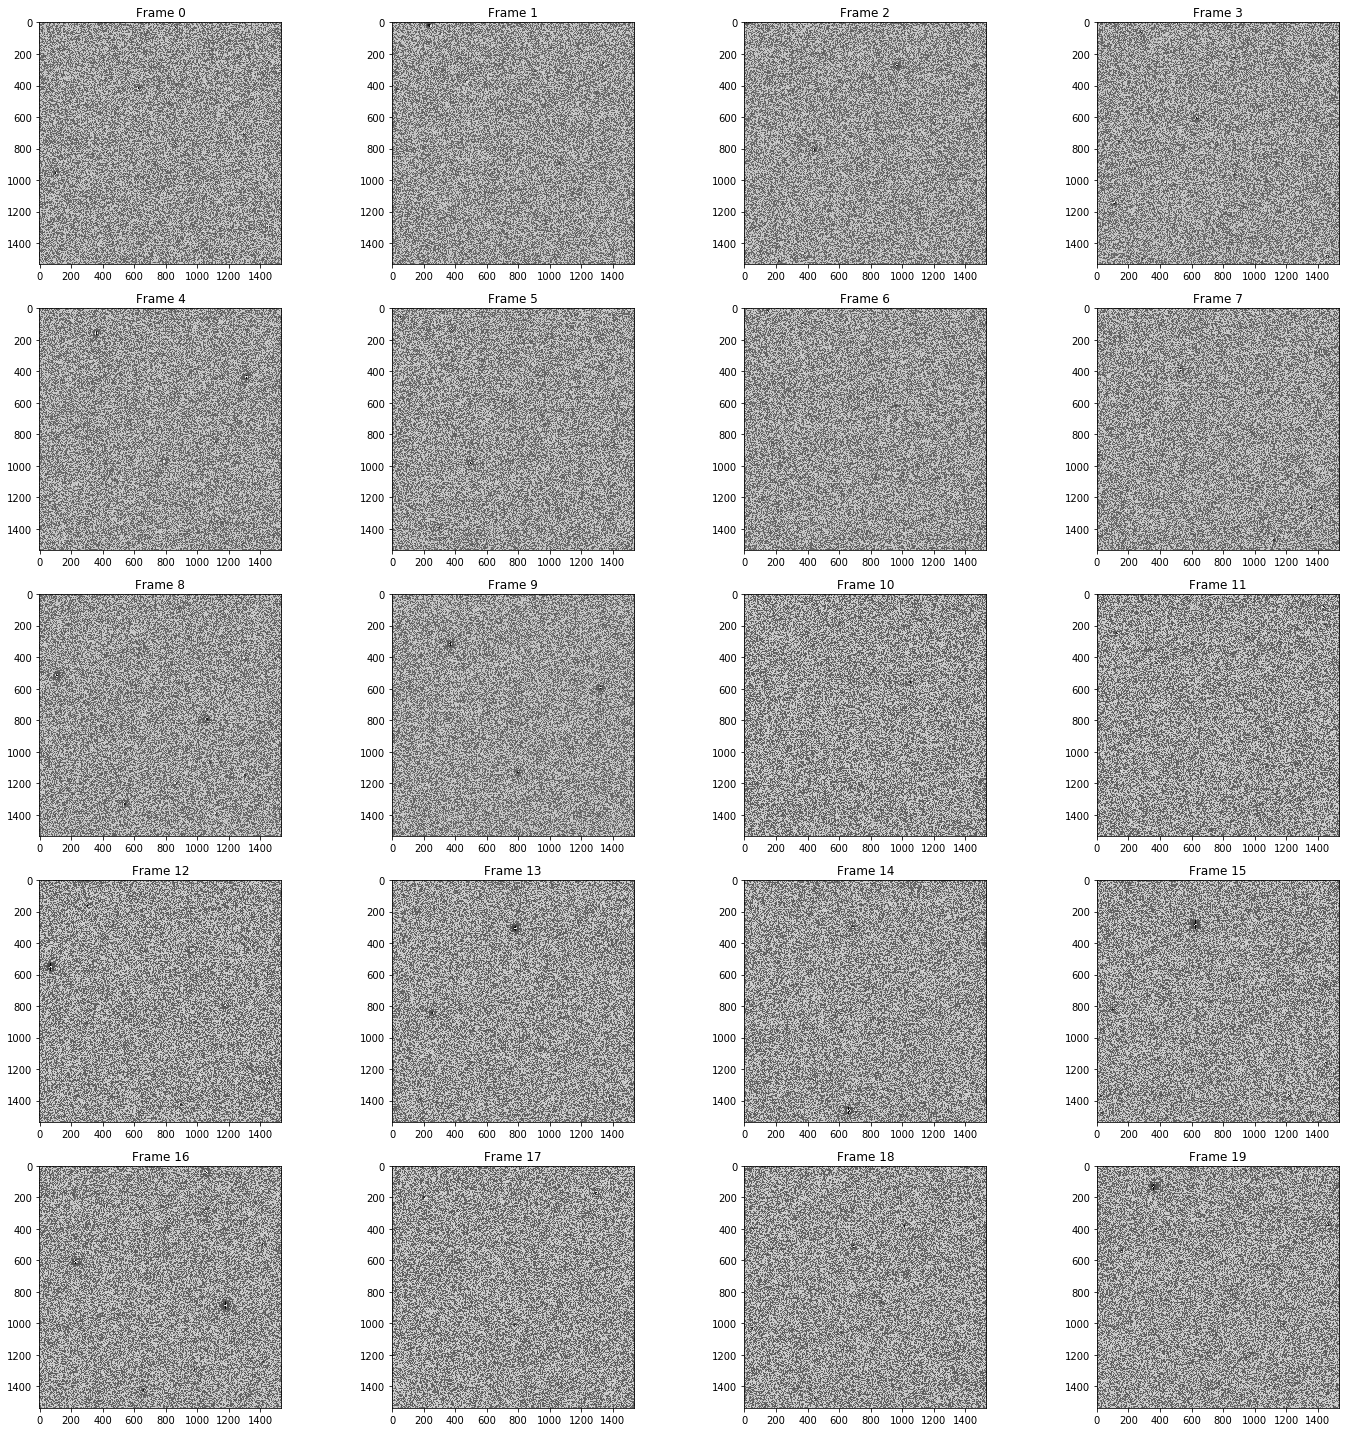

In [8]:
cmap = plt.get_cmap('Greys')
norm = colors.SymLogNorm(1)

ncols = 4
nrows = nframes // ncols
fig, axes = plt.subplots(nrows, ncols, figsize=(20,20))

for i in range(ncols):
    for j in range(nrows):
        frame = i + j * 4
        frame_data = fits.open(os.path.join(levmar_dir, f'_residual_{frame}.fits'))[0].data
        axes[j, i].set_title(f'Frame {frame}')
        axes[j, i].imshow(frame_data, cmap=cmap, norm=norm)

plt.tight_layout()
plt.show()

## GSL run

In [9]:
gsl_dir = '/home/aalvarez/Work/Data/sim09/gsl/'
gsl_log = open(os.path.join(gsl_dir, 'sim09.log')).read()

In [10]:
rengine = re.search('Using engine \w+', gsl_log)
gsl_log[rengine.start():rengine.end()]

'Using engine gsl'

In [11]:
re.findall('Elapsed: \d+:\d+:\d+', gsl_log)[-1]

'Elapsed: 00:43:25'

First approach takes longer. May be possible to play with the parameters?

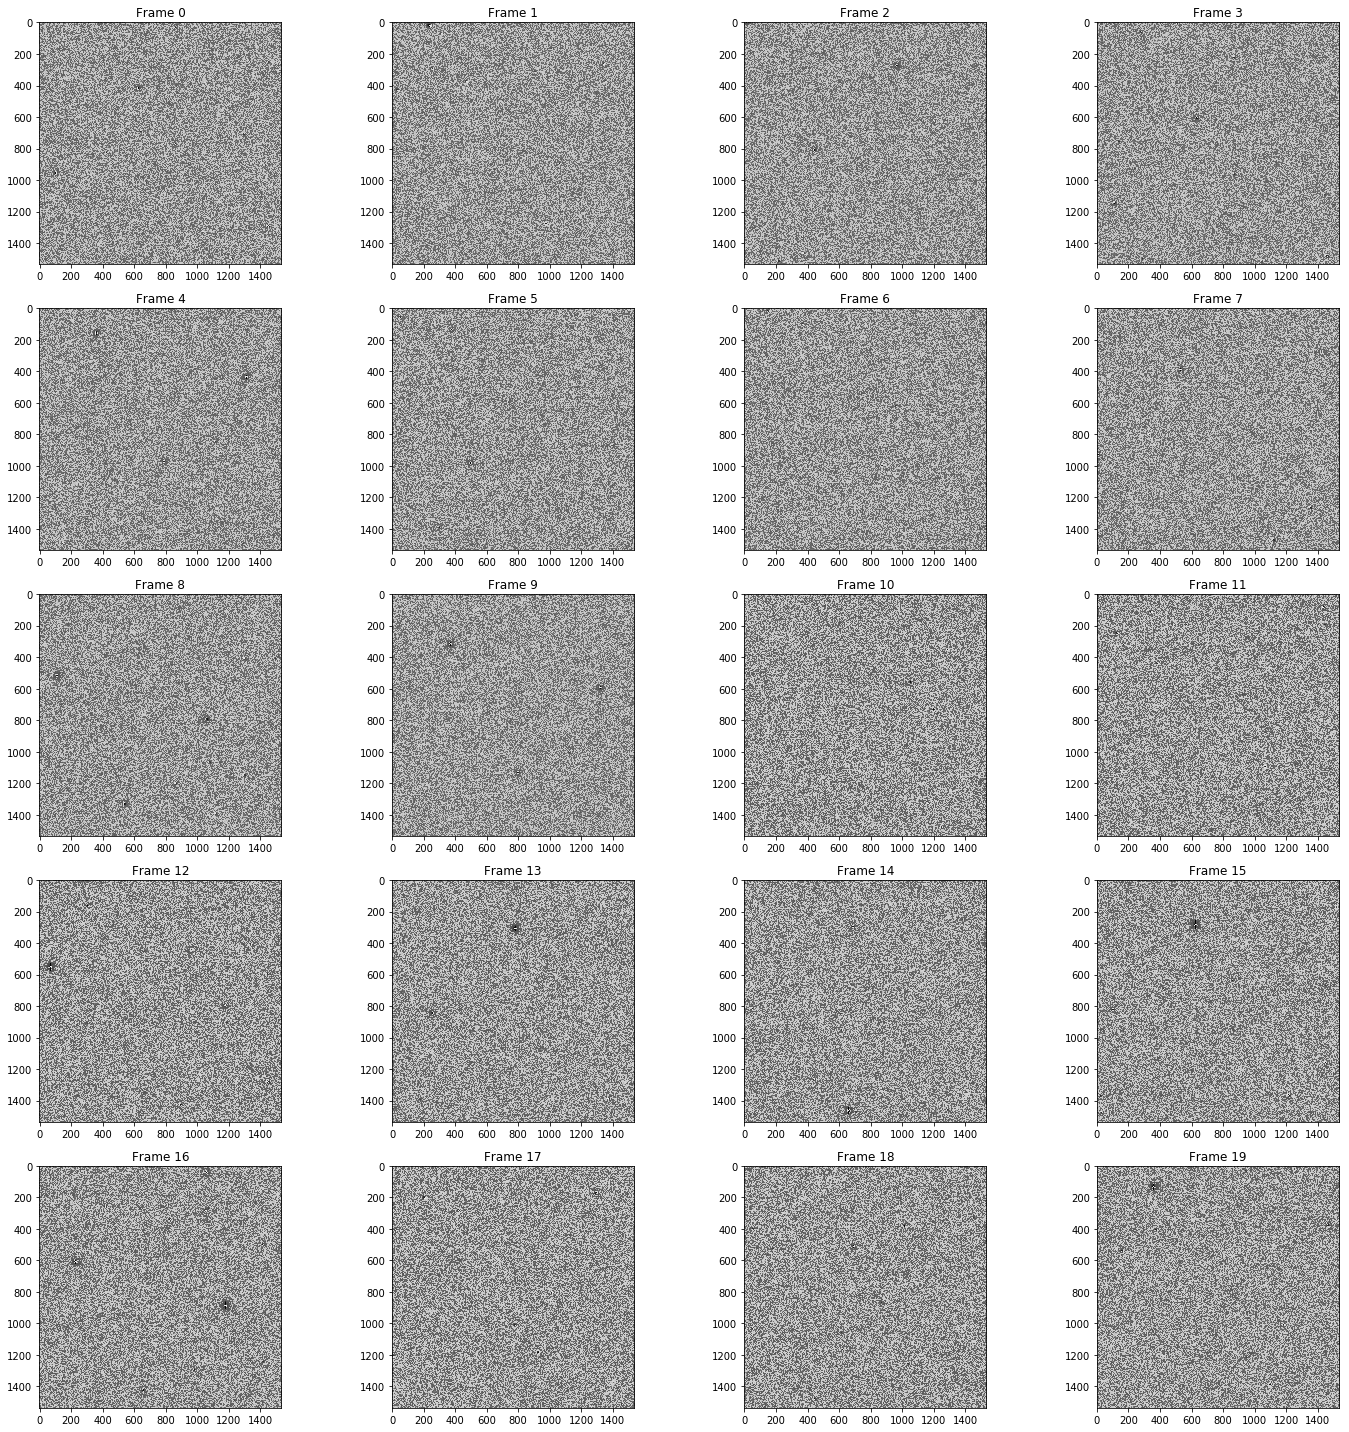

In [12]:
fig, axes = plt.subplots(nrows, ncols, figsize=(20,20))

for i in range(ncols):
    for j in range(nrows):
        frame = i + j * 4
        frame_data = fits.open(os.path.join(gsl_dir, f'_residual_{frame}.fits'))[0].data
        axes[j, i].set_title(f'Frame {frame}')
        axes[j, i].imshow(frame_data, cmap=cmap, norm=norm)

plt.tight_layout()
plt.show()

## Compare

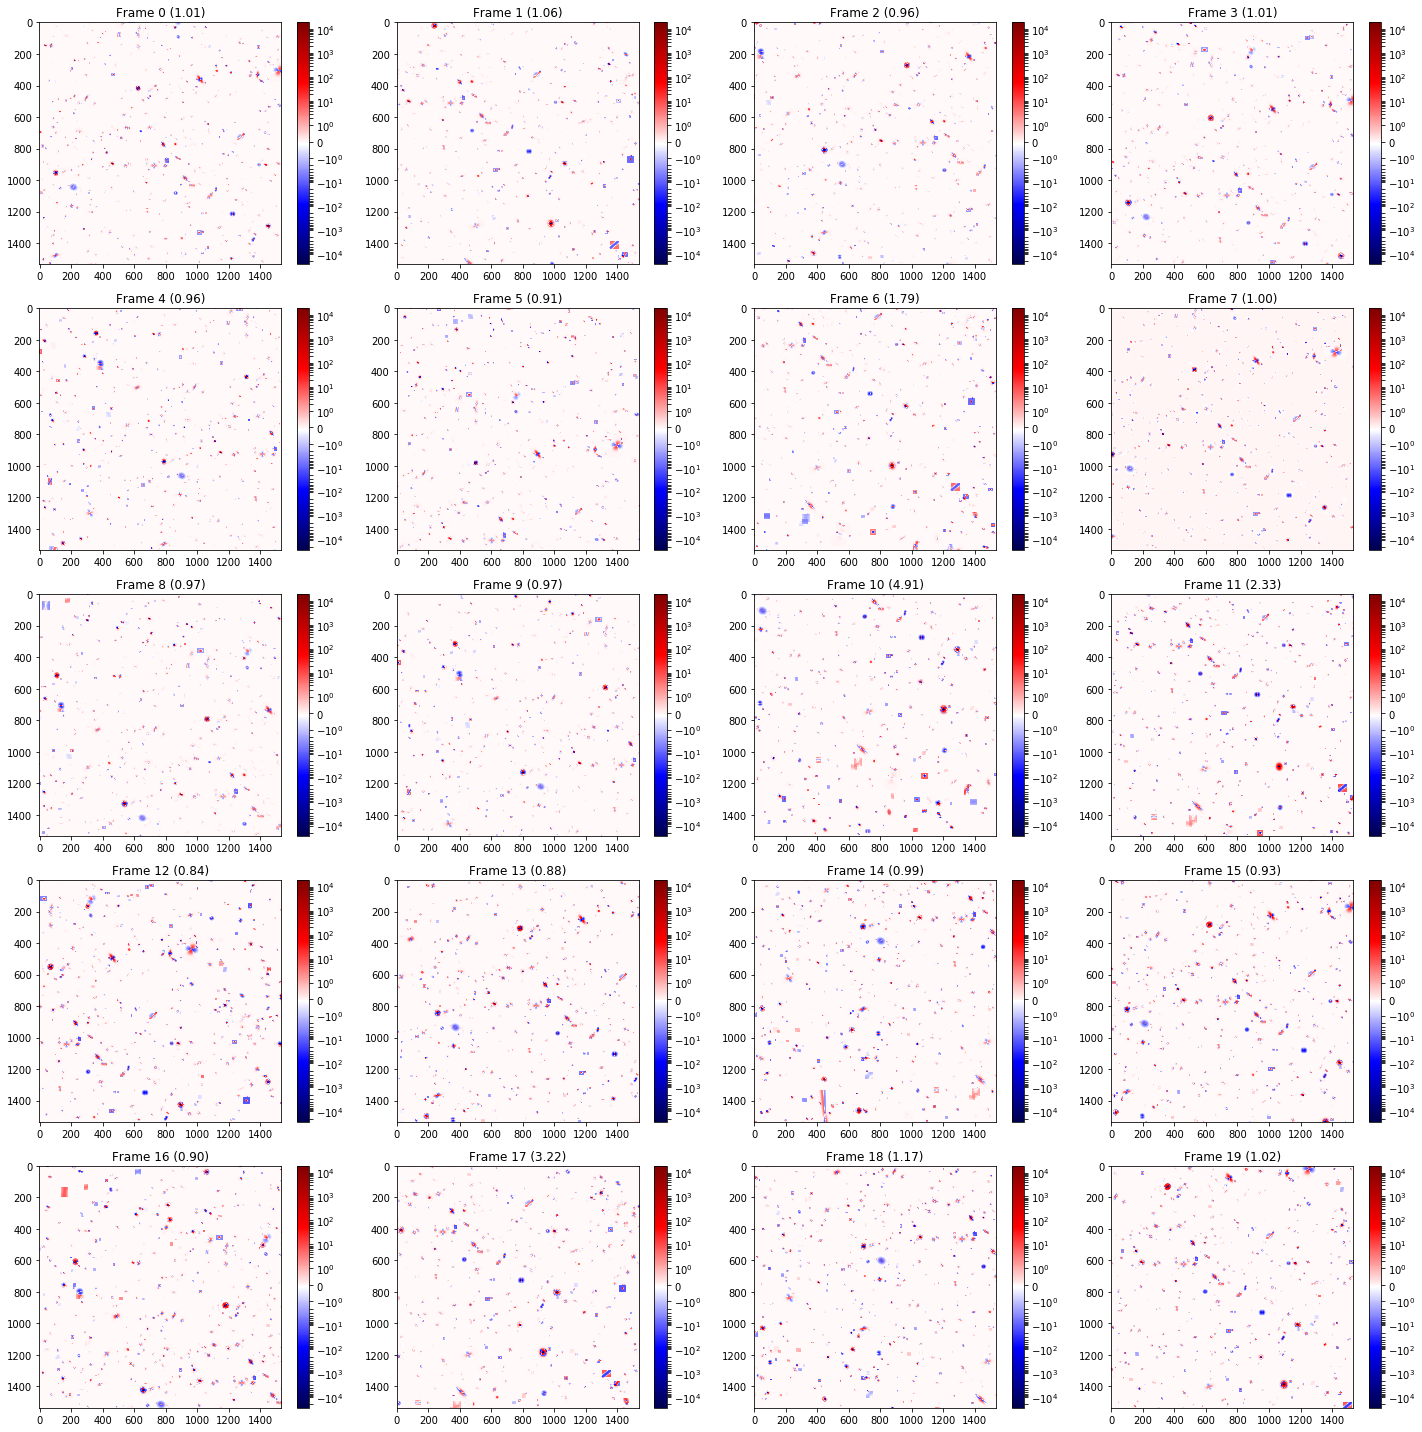

In [13]:
fig, axes = plt.subplots(nrows, ncols, figsize=(20,20))
diff_norm = colors.SymLogNorm(1)
levmar_total_residual = 0
gsl_total_residual = 0

for i in range(ncols):
    for j in range(nrows):
        frame = i + j * 4
        levmar_residual = fits.open(os.path.join(levmar_dir, f'_residual_{frame}.fits'))[0].data
        gsl_residual = fits.open(os.path.join(gsl_dir, f'_residual_{frame}.fits'))[0].data
        levmar_total_residual += levmar_residual.sum()
        gsl_total_residual += gsl_residual.sum()
        ratio = gsl_residual.sum() / levmar_residual.sum()
        axes[j, i].set_title(f'Frame {frame} ({ratio:.2f})')
        im = axes[j, i].imshow(levmar_residual-gsl_residual, cmap=plt.get_cmap('seismic'), norm=diff_norm)
        plt.colorbar(im, ax=axes[j, i])

plt.tight_layout()
plt.show()

In [14]:
print(gsl_total_residual**2/levmar_total_residual**2)

1.004336031327993


Detailed:

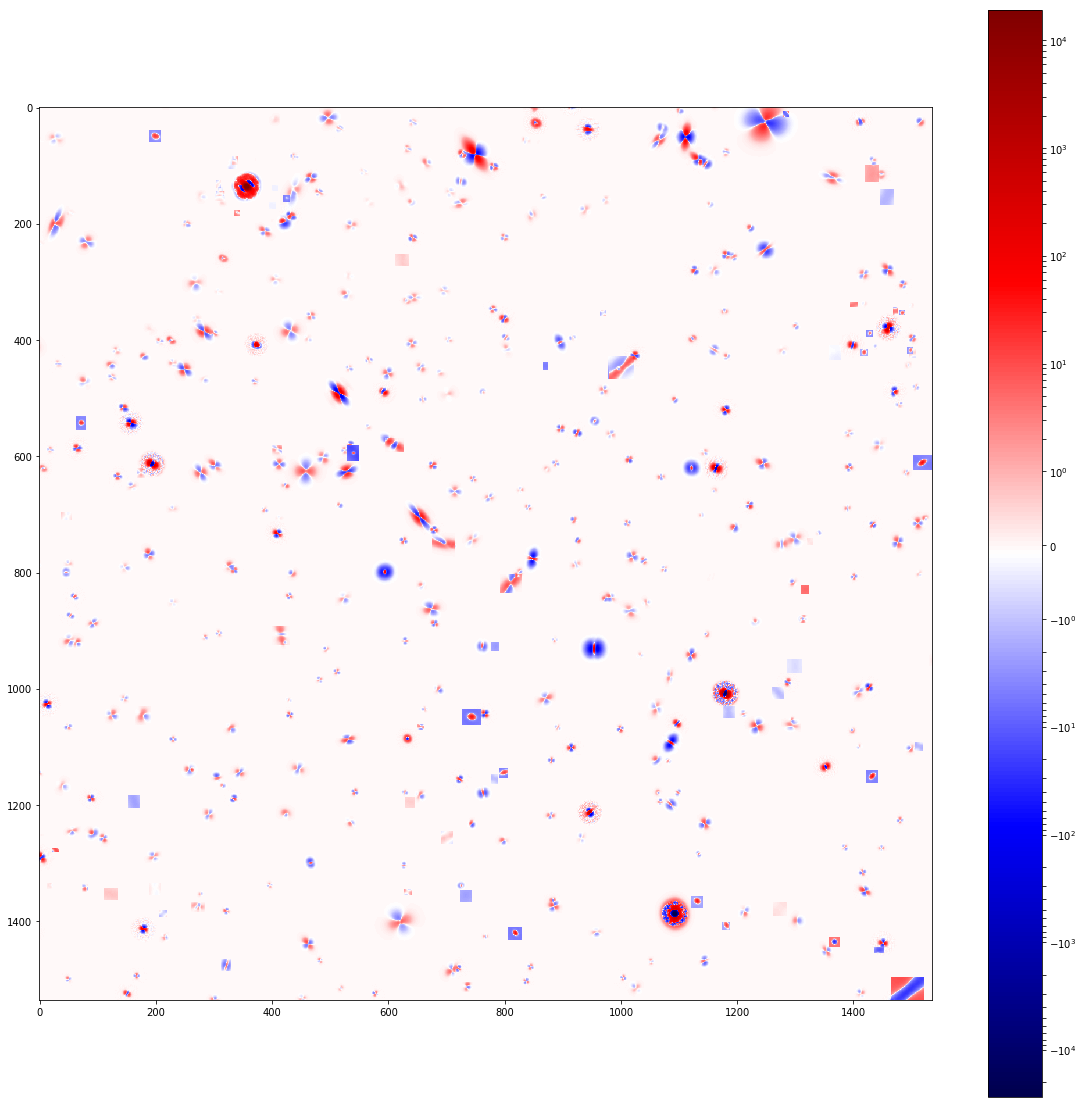

In [15]:
plt.figure(figsize=(20,20))
plt.imshow(levmar_residual-gsl_residual, cmap=plt.get_cmap('seismic'), norm=diff_norm)
plt.colorbar()
plt.show()

Even though the residuals looks kind of similar, they deffinitely are not. Oddly, it seems like there is some kind of simmetry, or rotation. It does not look random to me.

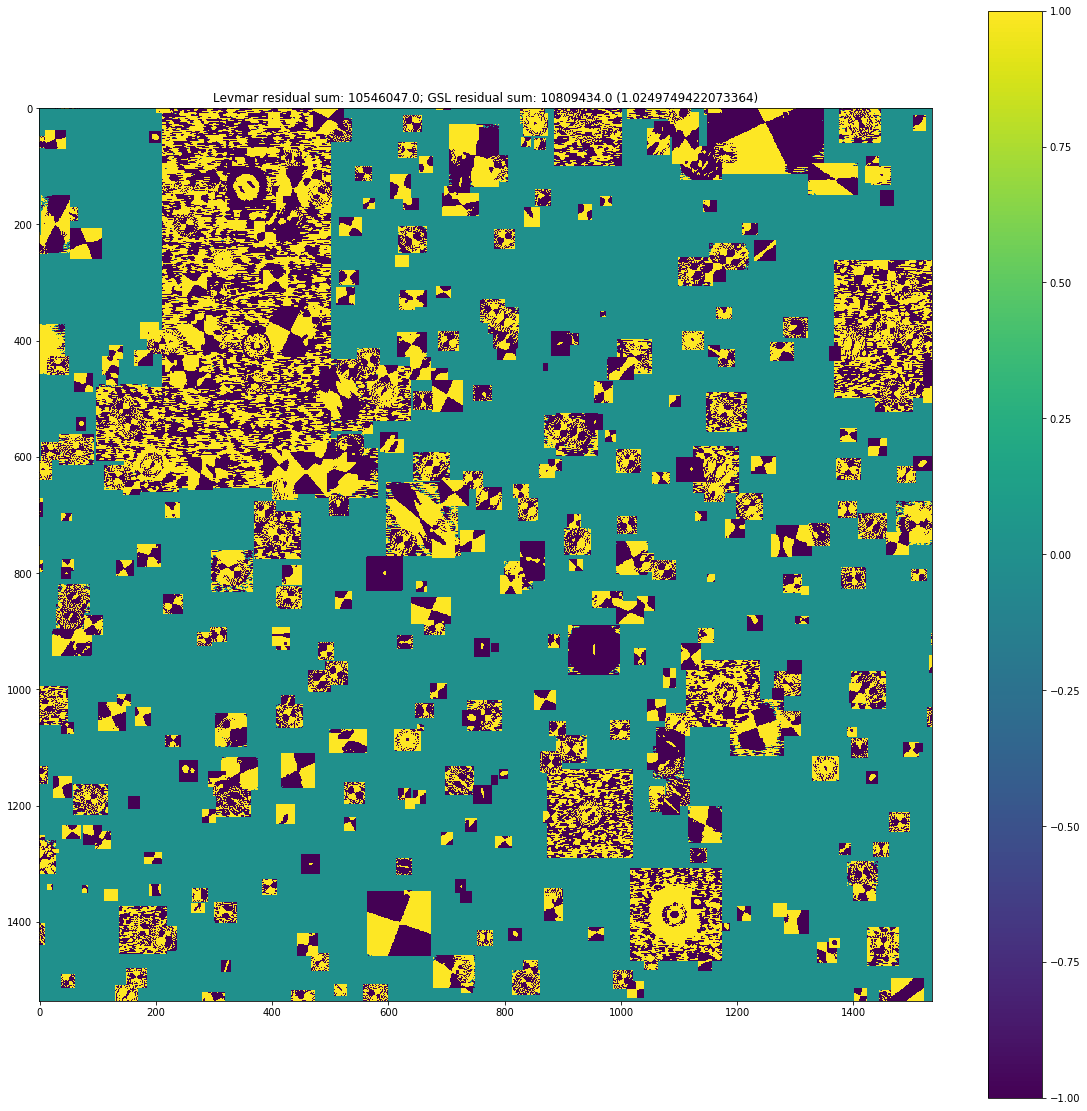

In [16]:
diff = levmar_residual - gsl_residual
masked = np.zeros(diff.shape)
masked[diff > 0] = 1
masked[diff < 0] = -1
plt.figure(figsize=(20,20))
plt.imshow(masked)
plt.title(f'Levmar residual sum: {levmar_residual.sum()}; GSL residual sum: {gsl_residual.sum()} ({gsl_residual.sum()/levmar_residual.sum()})')
plt.colorbar()

## Compare catalogs

In [17]:
levmar_cat = Table.read(os.path.join(levmar_dir, 'sim09_cat.fits'))
gsl_cat = Table.read(os.path.join(gsl_dir, 'sim09_cat.fits'))
sim09_r = Simulation('/home/aalvarez/Work/Data/sim09/sim09_r.list', mag_zeropoint=26, exposure=300)
sim09_g = Simulation('/home/aalvarez/Work/Data/sim09/sim09_g.list', mag_zeropoint=26, exposure=300)
sim09_r_img = Image('/home/aalvarez/Work/Data/sim09/sim09_r.fits')
sim09_g_img = Image('/home/aalvarez/Work/Data/sim09/sim09_g.fits')

In [18]:
crossval_r = CrossValidation(sim09_r_img, sim09_r, max_dist=1.5)
crossval_g = CrossValidation(sim09_g_img, sim09_g, max_dist=1.5)

In [19]:
gsl_cross_r = crossval_r(gsl_cat['x'], gsl_cat['y'])
levmar_cross_r = crossval_r(levmar_cat['x'], levmar_cat['y'])
gsl_cross_g = crossval_g(gsl_cat['x'], gsl_cat['y'])
levmar_cross_g = crossval_g(levmar_cat['x'], levmar_cat['y'])

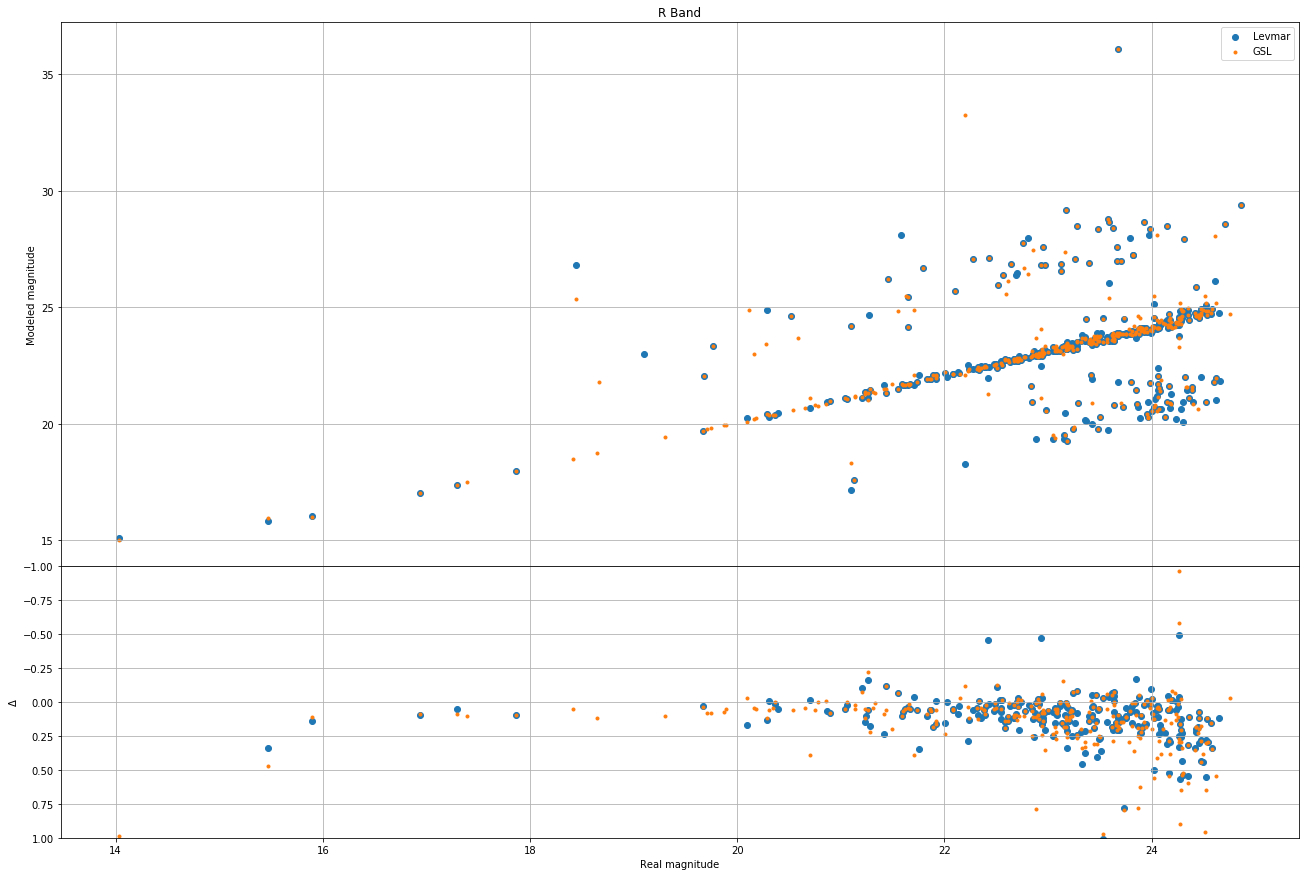

In [20]:
fig = plt.figure(figsize=(20, 15))
fig.subplots_adjust(left=0.07, right=0.93, hspace=0.0, wspace=0.2)
gridspec = GridSpec(3, 1)

ax_mag = fig.add_subplot(gridspec.new_subplotspec((0, 0), 2))
ax_mag.set_title('R Band')
ax_mag.set_ylabel('Modeled magnitude')
ax_mag.set_xlabel('Real magnitude')
ax_mag.scatter(levmar_cross_r.all_magnitudes, levmar_cat[levmar_cross_r.all_catalog]['mag_r'], label='Levmar', marker='o')
ax_mag.scatter(gsl_cross_r.all_magnitudes, gsl_cat[gsl_cross_r.all_catalog]['mag_r'], label='GSL', marker='.')
ax_mag.grid(True)
ax_mag.legend()

ax_diff = fig.add_subplot(gridspec.new_subplotspec((2, 0), 1))
ax_diff.set_ylabel('$\Delta$')
ax_diff.set_xlabel('Real magnitude')
ax_diff.scatter(levmar_cross_r.all_magnitudes, levmar_cat[levmar_cross_r.all_catalog]['mag_r'] - levmar_cross_r.all_magnitudes, label='Levmar', marker='o')
ax_diff.scatter(gsl_cross_r.all_magnitudes, gsl_cat[gsl_cross_r.all_catalog]['mag_r'] - gsl_cross_r.all_magnitudes, label='GSL', marker='.')
ax_diff.set_ylim(1, -1)
ax_diff.grid(True)

plt.show()

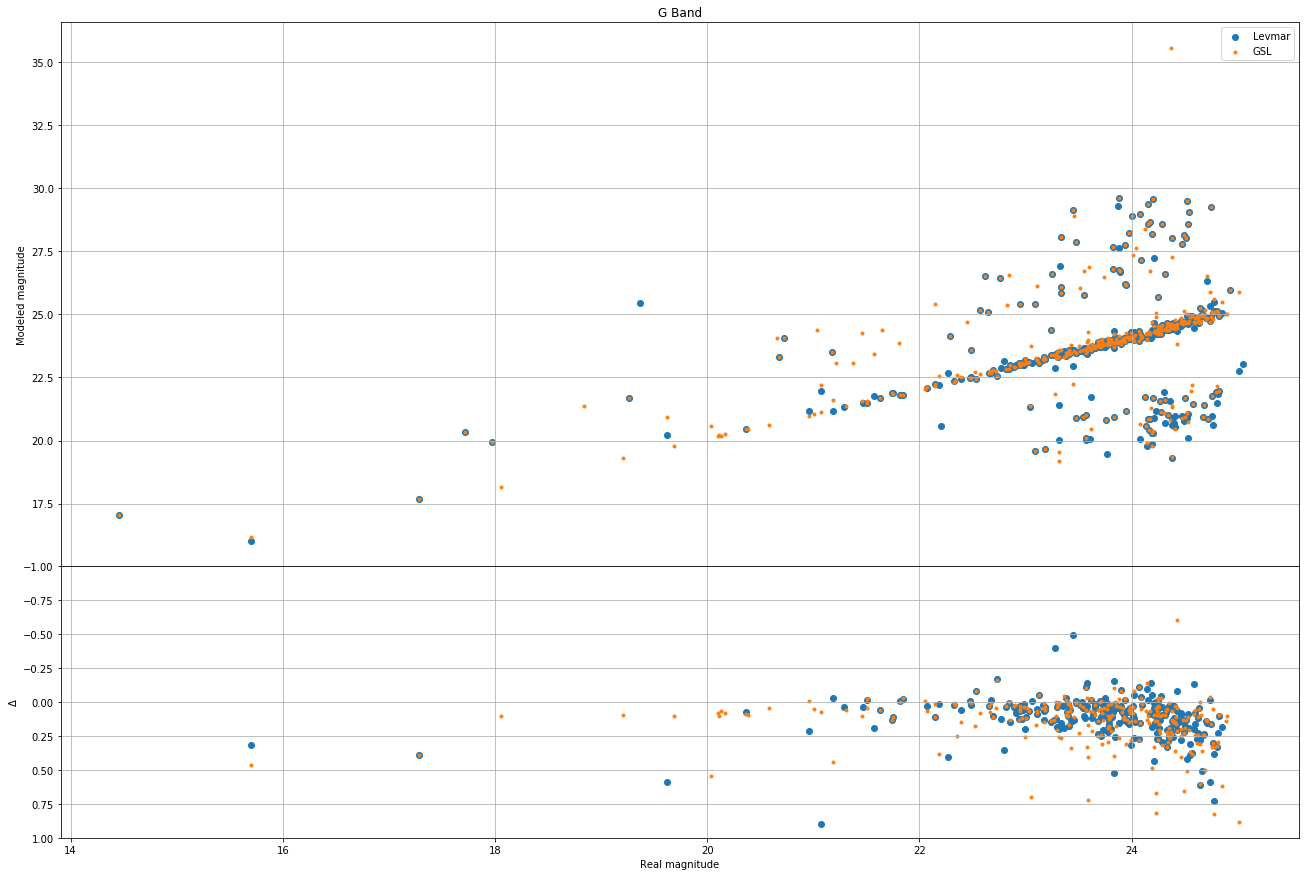

In [21]:
fig = plt.figure(figsize=(20, 15))
fig.subplots_adjust(left=0.07, right=0.93, hspace=0.0, wspace=0.2)
gridspec = GridSpec(3, 1)

ax_mag = fig.add_subplot(gridspec.new_subplotspec((0, 0), 2))
ax_mag.set_title('G Band')
ax_mag.set_ylabel('Modeled magnitude')
ax_mag.set_xlabel('Real magnitude')
ax_mag.scatter(levmar_cross_g.all_magnitudes, levmar_cat[levmar_cross_g.all_catalog]['mag_g'], label='Levmar', marker='o')
ax_mag.scatter(gsl_cross_g.all_magnitudes, gsl_cat[gsl_cross_g.all_catalog]['mag_g'], label='GSL', marker='.')
ax_mag.grid(True)
ax_mag.legend()

ax_diff = fig.add_subplot(gridspec.new_subplotspec((2, 0), 1))
ax_diff.set_ylabel('$\Delta$')
ax_diff.set_xlabel('Real magnitude')
ax_diff.scatter(levmar_cross_g.all_magnitudes, levmar_cat[levmar_cross_g.all_catalog]['mag_g'] - levmar_cross_g.all_magnitudes, label='Levmar', marker='o')
ax_diff.scatter(gsl_cross_g.all_magnitudes, gsl_cat[gsl_cross_g.all_catalog]['mag_g'] - gsl_cross_g.all_magnitudes, label='GSL', marker='.')
ax_diff.set_ylim(1, -1)
ax_diff.grid(True)

plt.show()